In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [3]:
# Load datas and drop NaN rows

stock_prices_df = pd.read_csv("./datas/CAC_40.csv", index_col="Date")
stock_prices_df.dropna(inplace=True)

In [4]:
# Max common period
print("{} - {}".format(stock_prices_df.index[0], stock_prices_df.index[-1]))
print("{} listing days".format(len(stock_prices_df)))

2014-06-27 - 2023-06-19
2297 listing days


In [5]:
# Select desired time_period --> TO BE IMPROVED
nb_days = 500
stock_prices_df = stock_prices_df.iloc[-nb_days:, :]
print("{} - {}".format(stock_prices_df.index[0], stock_prices_df.index[-1]))

2021-07-08 - 2023-06-19


In [6]:
def compute_returns(stock_prices_df, continuous=True):
    # Dividends not included --> TO BE IMPROVED
    
    returns_df = stock_prices_df.copy()
    
    if continuous: # Continuous returns
        for col in returns_df.columns:
            returns_df[col] = np.log(returns_df[col].shift(1) / returns_df[col])
            
    else: # Discrete returns
        for col in returns_df.columns:
            returns_df[col] = returns_df[col].pct_change()
            
    return returns_df

In [7]:
# Compute daily returns (continuous)

daily_returns_df = compute_returns(stock_prices_df, continuous=True)
    
daily_returns_df.dropna(inplace=True)
market_returns_df = daily_returns_df["^FCHI"]
daily_returns_df.drop("^FCHI", axis=1, inplace=True)

# Compute optimal portfolio allocations

In [8]:
def expected_return(weights_vector, returns_vector):
    
    expected_return = weights_vector.T @ returns_vector
    expected_return = expected_return[0][0]
    
    return expected_return

In [9]:
def expected_variance(weights_vector, covariance_matrix):
    
    expected_variance = weights_vector.T @ covariance_matrix @ weights_vector
    expected_variance = expected_variance.values[0][0]
    
    return expected_variance

In [45]:
class PortfolioAllocation():
    """
    Class allowing to compute best allocations of investments (weights) in a panel of stocks to optmize risk/return couple. 
    
    args:
    - daily_returns_df (pd.DataFrame): panel of stocks prices over a selected period
    """
       
    def __init__(self, daily_returns_df):
        self.daily_returns_df = daily_returns_df
        
        # Compute returns for the period and reshape array
        total_period_returns = daily_returns_df.sum()
        self.returns_vector = np.array(total_period_returns).reshape(-1, 1)
        
        # Compute covariance matrix and its inverse
        self.covariance_matrix = self.daily_returns_df.cov()
        self.inv_covariance_matrix = np.linalg.inv(self.covariance_matrix)
        
        # Compute vector of ones and returns vector with ones column
        self.unit_vector = np.full((len(self.returns_vector), 1), 1)
        self.returns_unit = np.c_[self.returns_vector, self.unit_vector].T
        
        # Compute transormation matrix for efficient frontier --> compute directly in __init__ or in a dedicated function ?
        a = self.returns_unit @ self.inv_covariance_matrix @ self.returns_unit.T
        inv_a = np.linalg.inv(a)
        self.transfo_matrix = self.inv_covariance_matrix @ self.returns_unit.T @ inv_a
        
    def compute_GMVP_weights(self, display_results=True):
        """
        Compute GMVP (Global minimum variance portfolio) weights allocation.
        
        args:
        - display_results (bool): decide to display or not expected return, variance and volatility
        """
    
        self.GMVP_weights = (self.inv_covariance_matrix @ self.unit_vector) / (self.unit_vector.T @ self.inv_covariance_matrix @ self.unit_vector)
        self.expected_return_GMVP = expected_return(self.GMVP_weights, self.returns_vector)
        self.expected_variance_GMVP = expected_variance(self.GMVP_weights, self.covariance_matrix)

        if display_results:
            print("Expected return GMVP : {:.6f}".format(self.expected_return_GMVP))
            print("Expected variance GMVP : {:.6f}".format(self.expected_variance_GMVP))
            print("Expected volatility GMVP : {:.6f}".format(np.sqrt(self.expected_variance_GMVP)))
        
    def compute_efficient_portfolio_weights(self, target_return, display_results=True):
        """
        Compute portfolio weights allocation which minimizes variance for a given target return.
        
        args:
        - display_results (bool): decide to display or not expected return, variance and volatility
        """

        self.efficient_portfolio_weights = self.transfo_matrix @ np.array([target_return, 1]).reshape(-1, 1)
        self.expected_return_efficient_portfolio = expected_return(self.efficient_portfolio_weights, self.returns_vector)
        self.expected_variance_efficient_portfolio = expected_variance(self.efficient_portfolio_weights, self.covariance_matrix)
        
        if display_results:
            print("Expected return efficient portfolio : {:.6f}".format(self.expected_return_efficient_portfolio))
            print("Expected variance efficient portfolio : {:.6f}".format(self.expected_variance_efficient_portfolio))
            print("Expected volatility efficient portfolio : {:.6f}".format(np.sqrt(self.expected_variance_efficient_portfolio)))
        
    def plot_efficient_frontier(self):
        """
        Plot the line of efficient portfolio in the range [-50%, +50%] in a return/variance chart.
        """
        
        expected_returns = [i/100 for i in range(-50, 50, 1)] # Quid letting range as function parameter ? 
        expected_variances = []
        
        # Compute variances for each return specified in expected_returns
        for i in expected_returns:
            weights = self.transfo_matrix @ np.array([i, 1]).reshape(-1, 1)
            expected_var = expected_variance(weights, self.covariance_matrix)
            expected_variances.append(expected_var)
            
        # Plot the frontier and GMVP
        fig = plt.figure()
        
        plt.plot(expected_variances, expected_returns) # Frontier
        plt.scatter(self.expected_variance_GMVP, self.expected_return_GMVP) # GMVP
        plt.text(self.expected_variance_GMVP+(7*(10**-7)), self.expected_return_GMVP-(1*(10**-2)), "GMVP")
        
        plt.ylabel("Rentability")
        plt.xlabel("Variance")
        plt.show()

In [46]:
# Create a portfolio and computing optimal allocations
my_ptf = PortfolioAllocation(daily_returns_df)
my_ptf.compute_GMVP_weights()
print("-"*50)
my_ptf.compute_efficient_portfolio_weights(0.05)

Expected return GMVP : -0.102247
Expected variance GMVP : 0.000038
Expected volatility GMVP : 0.006124
--------------------------------------------------
Expected return efficient portfolio : 0.050000
Expected variance efficient portfolio : 0.000039
Expected volatility efficient portfolio : 0.006276


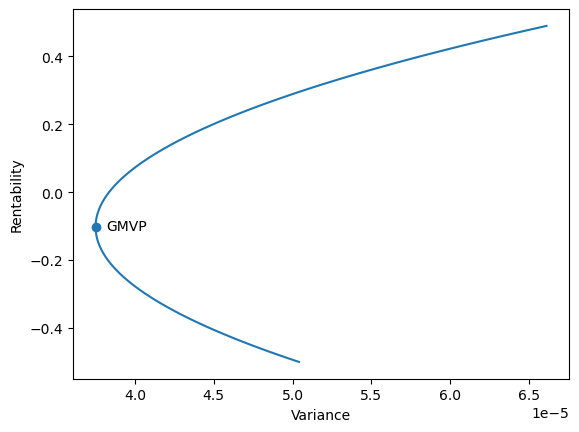

In [12]:
# Plot frontier
my_ptf.plot_efficient_frontier()

# Compute ratios

In [66]:
def compute_beta(stock_returns, market_returns):
    
    # Check if time period is identical
    if (stock_returns.index != market_returns.index).sum() != 0:
        raise ValueError("Periods of stock_returns and market_returns aren't identical")
        
    covariance_matrix = pd.DataFrame({'stock' : stock_returns, 'market' : market_returns}).cov()
    
    var_stock = covariance_matrix.iloc[0,0]
    var_market = covariance_matrix.iloc[1,1]
    covariance = covariance_matrix.iloc[0,1]
    
    beta = covariance / var_market
    
    return beta

In [83]:
def portfolio_metrics(daily_returns_df, market_returns, weights):
    
    betas_stocks = []
    
    # Compute beta for each individual stock in the portfolio
    for stock in daily_returns_df.columns:
        beta = compute_beta(daily_returns_df[stock], market_returns_df)
        betas_stocks.append(beta)
    
    # Compute the total beta for portfolio
    beta_ptf = np.array(betas_stocks) @ weights
    
    return betas_stocks, beta_ptf

In [86]:
betas_stocks, beta_ptf = portfolio_metrics(daily_returns_df, market_returns_df, my_ptf.efficient_portfolio_weights)

In [87]:
# Test beta with linear reg
from sklearn.linear_model import LinearRegression

model = LinearRegression()
model.fit(np.array(market_returns_df).reshape(-1, 1), np.array(daily_returns_df["ACA.PA"]).reshape(-1, 1))
model.coef_

array([[1.0877718]])